In [1]:
import copy
import os
import warnings

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt

# import collections
import matplotlib.ticker as mticker
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator
from scipy import signal

warnings.filterwarnings("ignore")
import importlib
import os

import eofs.standard as Eof_st
from eofs.multivariate.standard import MultivariateEof
from eofs.xarray import Eof
from scipy.signal import butter, convolve, lfilter


def reimport_module(module_name):
    """
    Reimports the specified Python module.

    Args:
    module_name (module): The module to be reimported, typically passed as a variable.

    Returns:
    module: The reloaded module.
    """
    try:
        # Reload the already imported module
        reloaded_module = importlib.reload(module_name)
        print(f"Module {module_name.__name__} reloaded successfully.")
        return reloaded_module
    except Exception as e:
        print(f"Failed to reload module: {e}")

In [2]:
bootstrap = True
if bootstrap:
    from xbootstrap import block_bootstrap

## Data Paths

In [3]:
###########################################################
####################### Template ##########################
###########################################################

# dir_in = '/glade/campaign/cgd/amp/wchapman/Reanalysis/ERA5_obs/'
# dir_out = '/glade/derecho/scratch/wchapman/ADF/ERA5_data/ts/climo/'
# f_in = 'e5.moda.an.pl.128_131_z.ll025sc.camgrid.1979.2022.nc'
# var_z = 'z'

###########################################################
####################### Template ##########################
###########################################################

# dir_in = "/glade/derecho/scratch/wchapman/ADF/FHIST_f09_g16/ts/"
# dir_out = "/glade/derecho/scratch/wchapman/ADF/FHIST_f09_g16/climo/"
# f_in = "FHIST_f09_g16.cam.h0.plev.Z3.197901-200512.nc"
# var_z = "Z3"

###########################################################
####################### Template ##########################
###########################################################

# dir_in = "/glade/derecho/scratch/wchapman/ADF/FHIST5_f09_g16_v2/ts/"
# dir_out = "/glade/derecho/scratch/wchapman/ADF/FHIST5_f09_g16_v2/climo/"
# f_in = "FHIST5_f09_g16_v2.cam.h0.plev.Z3.197901-200512.nc"
# var_z = "Z3"

###########################################################
####################### Template ##########################
###########################################################

# dir_in = "/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/ts/"
# dir_out = "/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/climo/"
# f_in = "CAM6_Betzy1.cam.h0.plev.Z3.197901-200512.nc"
# var_z = "Z3"

###########################################################
####################### Template ##########################
###########################################################

dir_in = "/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/ts/"
dir_out = "/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/climo/"
f_in = "CAM5_Betzy1.cam.h0.plev.Z3.197901-200512.nc"
var_z = "Z3"

## Functions

In [4]:
def Seas_Avg_TS(DS, var, numav):
    Seas_Avg = xr.zeros_like(DS)
    np_seasav = np.zeros_like(DS[var])
    for ii in range(len(DS["time"])):
        if ii + numav > len(DS["time"]):
            np_seasav[ii, :, :] = np.nan
        else:
            dingo = DS.isel(time=slice(ii, ii + numav))
            month_length = dingo.time.dt.days_in_month
            scaling = month_length / np.sum(month_length)
            np_seasav[ii, :, :] = (dingo[var] * scaling).sum(["time"])
    Seas_Avg[var].values = np_seasav
    Seas_Avg = Seas_Avg.dropna(dim="time")
    return Seas_Avg


def is_mon(month, monget):
    return month == monget


def fix_EOF(C_for, Pats):
    # Pats = ['NAM','SAM','PNA','NPO','NAO','PSA1','PSA2']
    C_for_rep = xr.zeros_like(C_for)

    # EOF_fix(Pats)
    for Pt in Pats:
        print(Pt)
        if Pt == "PNA":
            latdo = [30, 75]
            londo = [180, 220]

        if Pt == "NPO":
            latdo = [60, 89]
            londo = [0, 360]

        if Pt == "NAM":
            latdo = [60, 89]
            londo = [0, 360]

        if Pt == "SAM":
            latdo = [-89, -60]
            londo = [0, 360]

        if Pt == "PSA1":
            latdo = [-89, -60]
            londo = [0, 360]

        if Pt == "PSA2":
            latdo = [-89, -60]
            londo = [0, 360]

        if Pt == "NAO":
            latdo = [60, 89]
            londo = [0, 360]
        Replace_EOF = np.zeros_like(C_for[Pt])
        Replace_PC = np.zeros_like(C_for[Pt + "_PC"])
        for ii in range(len(C_for["member"])):
            if (
                np.sum(
                    C_for[Pt]
                    .sel(member=ii)
                    .sel(lat=slice(latdo[0], latdo[1]), lon=slice(londo[0], londo[1]))
                ).values
                > 0
            ):
                Replace_EOF[ii, :, :] = C_for[Pt].sel(member=ii).values * -1
                Replace_PC[ii, :] = C_for[Pt + "_PC"].sel(member=ii).values * -1
            else:
                Replace_EOF[ii, :, :] = C_for[Pt].sel(member=ii).values
                Replace_PC[ii, :] = C_for[Pt + "_PC"].sel(member=ii).values

        C_for_rep[Pt].values = Replace_EOF
        C_for_rep[Pt + "_PC"].values = Replace_PC
        C_for_rep[Pt + "_var_frac"].values = C_for[Pt + "_var_frac"].values
        C_for_rep[Pt + "_tot_var"].values = C_for[Pt + "_tot_var"].values
    return C_for_rep

## Open Dataset

In [5]:
%%time
if "ERA5" in dir_in:
    DS = xr.open_dataset(os.path.join(dir_in, f_in)).sel(level=500).squeeze()
else:
    DS = xr.open_dataset(os.path.join(dir_in, f_in)).sel(lev=500,method='nearest')
    DS = DS.resample(time="1MS").mean()
    tstrt = str(DS["time"][0].values)[:10]
    tend = str(DS["time"][-1].values)[:10]
    # Create the date range
    date_range = pd.date_range(start=tstrt, end=tend, freq="1MS")
    DS["time"] = date_range
    DS[var_z] = DS[var_z]

CPU times: user 440 ms, sys: 47.6 ms, total: 487 ms
Wall time: 490 ms


In [6]:
###
season = "DJF"
mon_dict = {
    "DJF": [3, 12, 1, 2],
    "MAM": [3, 3, 4, 5],
    "JJA": [3, 6, 7, 8],
    "SON": [3, 9, 10, 11],
    "ANN": [12, 1],
}
mon_retrieve = mon_dict[season][1]
roll_num = mon_dict[season][0]

Patssave = ["PNA", "NAO", "NPO"]
# Patssave = ['NPO','NAM','SAM']

for Pats in Patssave:
    Pats = [Pats]
    DS_roll = Seas_Avg_TS(DS, var_z, 1)
    # create seasons...
    DS_D = DS_roll.sel(time=is_mon(DS_roll["time.month"], mon_dict[season][1]))
    # remove mean
    DS_D = DS_D - DS_D.mean("time")
    DS_J = DS_roll.sel(time=is_mon(DS_roll["time.month"], mon_dict[season][2]))
    DS_J = DS_J - DS_J.mean("time")
    DS_F = DS_roll.sel(time=is_mon(DS_roll["time.month"], mon_dict[season][3]))
    DS_F = DS_F - DS_F.mean("time")
    DS_SEA = xr.merge([DS_D, DS_J, DS_F])[var_z]

    latshape = len(DS_SEA["lat"])
    lonshape = len(DS_SEA["lon"])
    subsel = np.arange(0, len(DS_SEA["time"]))

    for ee, pattern in enumerate(Pats):
        print("doing pattern: ", pattern)
        # modes defined here: https://opensky.ucar.edu/islandora/object/manuscripts:1001
        if pattern == "PNA":
            latdo = [20, 85]
            londo = [120, 240]
            getmode = 0

        if pattern == "NPO":
            latdo = [20, 85]
            londo = [120, 240]
            getmode = 1

        if pattern == "NAM":
            latdo = [20, 89]
            londo = [0, 360]
            getmode = 0

        if pattern == "SAM":
            latdo = [-89, -20]
            londo = [0, 360]
            getmode = 0

        if pattern == "PSA1":
            latdo = [-89, -20]
            londo = [0, 360]
            getmode = 1

        if pattern == "PSA2":
            latdo = [-89, -20]
            londo = [0, 360]
            getmode = 2

        if pattern == "NAO":
            latdo = [20, 80]
            londo = [-90, 40]
            getmode = 0

        # cosine weighting and take EOF ... of region...
        if pattern in ["NAM", "SAM", "PNA", "NPO", "PSA1", "PSA2"]:
            DS_reg_temp = DS_SEA.sel(
                lat=slice(latdo[0], latdo[1]), lon=slice(londo[0], londo[1])
            )

        elif pattern == "NAO":
            DS_reg_temp = copy.deepcopy(DS_SEA)
            DS_reg_temp.coords["lon"] = (DS_reg_temp.coords["lon"] + 180) % 360 - 180
            DS_reg_temp = DS_reg_temp.sortby(DS_reg_temp.lon).sel(
                lat=slice(latdo[0], latdo[1]), lon=slice(londo[0], londo[1])
            )

        latshape_reg = len(DS_reg_temp["lat"])
        lonshape_reg = len(DS_reg_temp["lon"])

        DA_do = copy.deepcopy(DS_reg_temp)
        coslat = np.cos(np.deg2rad(DA_do.coords["lat"].values))
        wgts = np.sqrt(coslat)[..., np.newaxis]
        solver = Eof(DA_do, weights=wgts, center=False)
        pc1 = solver.pcs(npcs=10, pcscaling=1).sel(mode=getmode)

        # solve the regression problem as a covariance problem....
        bb = ma.dot((DS_SEA).stack(allpoints=["lat", "lon"]).T, pc1) / (len(pc1) - 1)
        patdone = bb.reshape([latshape, lonshape])
        ##reconstruction

        Recon_pattern = solver.reconstructedField(neofs=[getmode + 1])
        Recon_pattern_var = Recon_pattern.var("time")
        # full_Recon_pattern[ense_r,:,:]=Recon_pattern_var

        full_Recon_pattern = np.zeros(
            [101, Recon_pattern_var["lat"].shape[0], Recon_pattern_var["lon"].shape[0]]
        )

        PatdoneENS = np.zeros([101, latshape, lonshape])
        PatdoneENS[0, :, :] = patdone
        fullpc = np.zeros([101, pc1.shape[0]])
        fullpc[0, :] = np.array(pc1).squeeze()
        full_Recon_pattern[0, :, :] = Recon_pattern_var
        var_exp = np.zeros([101])
        var_exp[0] = np.array(solver.varianceFraction(neigs=10))[getmode]

        # bootstrap
        print(".... create block ensemble ...")
        pfield_bs = block_bootstrap(
            DS_SEA,
            blocks={"time": 1},
            n_iteration=100,
            circular=False,
        )

        for rr in range(100):
            if rr % 20 == 0:
                print(f"doing: {rr}")
            itty = pfield_bs[:, :, :, rr]

            # cosine weighting and take EOF ... of region...
            if pattern in ["NAM", "SAM", "PNA", "NPO", "PSA1", "PSA2"]:
                DS_reg_temp = itty.sel(
                    lat=slice(latdo[0], latdo[1]), lon=slice(londo[0], londo[1])
                )

            elif pattern == "NAO":
                DS_reg_temp = copy.deepcopy(itty)
                DS_reg_temp.coords["lon"] = (
                    DS_reg_temp.coords["lon"] + 180
                ) % 360 - 180
                DS_reg_temp = DS_reg_temp.sortby(DS_reg_temp.lon).sel(
                    lat=slice(latdo[0], latdo[1]), lon=slice(londo[0], londo[1])
                )

            coslat = np.cos(np.deg2rad(DS_reg_temp.coords["lat"].values))
            wgts = np.sqrt(coslat)[..., np.newaxis]
            solver = Eof(
                DS_reg_temp.transpose("time", "lat", "lon"), weights=wgts, center=False
            )
            pc1 = solver.pcs(npcs=10, pcscaling=1).sel(mode=getmode)

            # solve the regression problem as a covariance problem....
            bb = ma.dot((itty).stack(allpoints=["lat", "lon"]).T, pc1) / (len(pc1) - 1)
            patdone = bb.reshape([latshape, lonshape])
            ##reconstruction
            Recon_pattern = solver.reconstructedField(neofs=[getmode + 1])
            Recon_pattern_var = Recon_pattern.var("time")
            PatdoneENS[rr + 1, :, :] = patdone
            fullpc[rr + 1, :] = np.array(pc1).squeeze()
            full_Recon_pattern[rr + 1, :, :] = Recon_pattern_var
            var_exp[rr + 1] = np.array(solver.varianceFraction(neigs=10))[getmode]

        C_for = xr.Dataset(
            {
                pattern: (["member", "lat", "lon"], PatdoneENS),
                pattern + "_PC": (["member", "time"], np.array(fullpc).squeeze()),
                pattern + "_var_frac": (["member"], var_exp.squeeze()),
                pattern
                + "_tot_var": (
                    ["member", "lat_reg", "lon_reg"],
                    full_Recon_pattern.squeeze(),
                ),
            },
            coords={
                "member": np.arange(0, 101),
                "lat": np.array(DS["lat"]),
                "lon": np.array(DS["lon"]),
                "time": pc1["time"].data[:],
                "lat_reg": np.array(Recon_pattern_var["lat"]),
                "lon_reg": np.array(Recon_pattern_var["lon"]),
            },
        )
        C_for.attrs["title"] = "EOFs of member"
        C_for[pattern].attrs["units"] = "PA"
        C_for[pattern].attrs[
            "standard_name"
        ] = "Pattern Regressed on PC scaled to unit variance "
        C_for[pattern + "_PC"].attrs["standard_name"] = "PC scaled to unit variance "
        C_for_fix = fix_EOF(C_for, Pats)
        C_for_fix.to_netcdf(f"{dir_out }/{Pats[0]}_bootstrapped_modes_{season}.nc")

doing pattern:  PNA
.... create block ensemble ...
doing: 0
doing: 20
doing: 40
doing: 60
doing: 80
PNA
doing pattern:  NAO
.... create block ensemble ...
doing: 0
doing: 20
doing: 40
doing: 60
doing: 80
NAO
doing pattern:  NPO
.... create block ensemble ...
doing: 0
doing: 20
doing: 40
doing: 60
doing: 80
NPO


In [10]:
Pats = ["NAO"]
pattern = Pats[0]
DSpat = xr.open_dataset(f"{dir_out }/{Pats[0]}_bootstrapped_modes_{season}.nc")

plotting member:  30


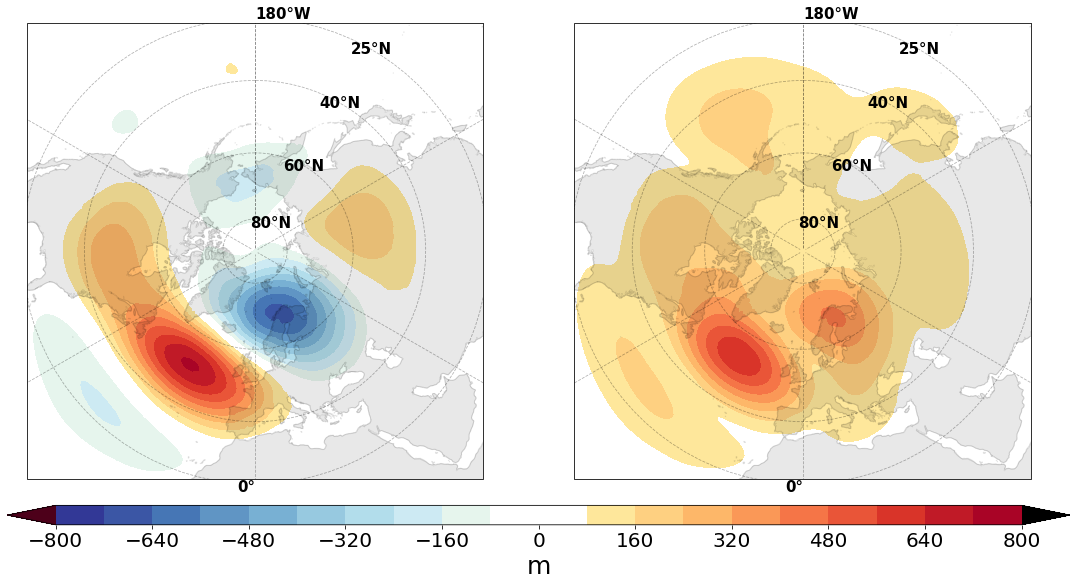

In [12]:
#### --- colormap
#### ++ init fig
fig = plt.figure(figsize=[18, 9])
memno = 30  # member to plot...
se = [-180, 180, 26, 90]
#### -- init fig

print("plotting member: ", memno)
Max_Pascal = 800
cmap = plt.colormaps["RdYlBu_r"]

cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N - 1] = cmap(0.99)

for ii in range(120, 136):
    cmaplist[ii] = [1, 1, 1, 1]
cmap.N
# create the new map
cmap = cmap.from_list("My cmap", cmaplist, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over("k")

levels = MaxNLocator(nbins=23).tick_values(-Max_Pascal, Max_Pascal)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

### +++ fig left
ax1 = fig.add_subplot(121, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(
    draw_labels=True,
    xlocs=None,
    ylocs=[25, 40, 60, 80],
    color="black",
    alpha=0.3,
    linestyle="--",
)
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"weight": "bold", "size": 15, "color": "black", "rotation": 0}
gl.ylabel_style = {"weight": "bold", "size": 15, "color": "black"}
ax1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "50m", edgecolor="face", facecolor="k", alpha=0.09
    )
)
lat = DSpat["lat"]
lon = DSpat["lon"]
lat_reg = DSpat["lat_reg"]
lon_reg = DSpat["lon_reg"]

###### +++add cyclic point
plotter = DSpat[Pats[0]].sel(member=0)*9.81
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

# perc_contour2[np.abs(plotter)<10]=0 #set below thresh to zero
cs2 = ax1.contourf(
    lon_cyclic,
    lat,
    plotter_cyclic,
    levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    extend="both",
)
# cs3=ax1.contourf(np.array(lon_reg),lat_reg,np.array(perc_contour2),levels =[600,800,999], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')

# # ------------------------------
# # New bit here that handles changing the color of hatches
# colors = ['xkcd:burnt orange', 'xkcd:teal', 'darkorange', 'gold', 'forestgreen',
#           'darkturquoise', 'dodgerblue', 'darkviolet']
# # For each level, we set the color of its hatch
# for i, collection in enumerate(cs3.collections):
#     collection.set_edgecolor(colors[i % len(colors)])
# # Doing this also colors in the box around each level
# # We can remove the colored line around the levels by setting the linewidth to 0
# for collection in cs3.collections:
#     collection.set_linewidth(0.)
# # ------------------------------
ax1.set_extent(se, crs=ccrs.PlateCarree())
### --- fig left


### +++ fig middle
ax1 = fig.add_subplot(122, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(
    draw_labels=True,
    xlocs=None,
    ylocs=[25, 40, 60, 80],
    color="black",
    alpha=0.3,
    linestyle="--",
)
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"weight": "bold", "size": 15, "color": "black", "rotation": 0}
gl.ylabel_style = {"weight": "bold", "size": 15, "color": "black"}
ax1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "50m", edgecolor="face", facecolor="k", alpha=0.09
    )
)
lat = DSpat["lat"]
lon = DSpat["lon"]
lat_reg = DSpat["lat_reg"]
lon_reg = DSpat["lon_reg"]

###### +++add cyclic point
plotter = DSpat[Pats[0]].std("member")*9.81
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

# perc_contour2[np.abs(plotter)<10]=0 #set below thresh to zero
cs2 = ax1.contourf(
    lon_cyclic,
    lat,
    plotter_cyclic,
    levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    extend="both",
)
# cs3=ax1.contourf(np.array(lon_reg),lat_reg,np.array(perc_contour2),levels =[600,800,999], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')

# # ------------------------------
# # New bit here that handles changing the color of hatches
# colors = ['xkcd:burnt orange', 'xkcd:teal', 'darkorange', 'gold', 'forestgreen',
#           'darkturquoise', 'dodgerblue', 'darkviolet']
# # For each level, we set the color of its hatch
# for i, collection in enumerate(cs3.collections):
#     collection.set_edgecolor(colors[i % len(colors)])
# # Doing this also colors in the box around each level
# # We can remove the colored line around the levels by setting the linewidth to 0
# for collection in cs3.collections:
#     collection.set_linewidth(0.)
# # ------------------------------
ax1.set_extent(se, crs=ccrs.PlateCarree())
### --- fig middle
##+++inset colorbar:
ax4 = fig.add_axes([0.11, 0.08, 0.82, 0.03])
cb = mpl.colorbar.ColorbarBase(
    ax4,
    cmap=cmap,
    norm=norm,
    extend="both",
    spacing="proportional",
    ticks=levels[::2],
    boundaries=levels,
    orientation="horizontal",
)
ax4.set_xlabel("m", size=25)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
##---inset colorbar: